In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import RootMeanSquaredError
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from datetime import datetime


In [2]:
# Load the datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [4]:
train.describe()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


## Cleaning up the data

To clean the data I did the following:
1. Converted values in the datetime column into pandas datetime objects.
2. Set the datetime column as the index for the data.
3. Filled in the missing values by interpolating values within the dataset as interpolation provides a more accurate estimate based on neighbouring values. However for values at the beginning or end of the dataset that cannot be interpolated, I am going to fill them with the mean.

In [5]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# Fill in missing values
# First I am going to interpolate missing values in the middle rows
# Then, I am going to fill the missing values at the beginning of the dataset
train['pm2.5'] = train['pm2.5'].fillna(train['pm2.5'].interpolate()).fillna(train['pm2.5'].mean())

test.fillna(test.interpolate(), inplace=True)

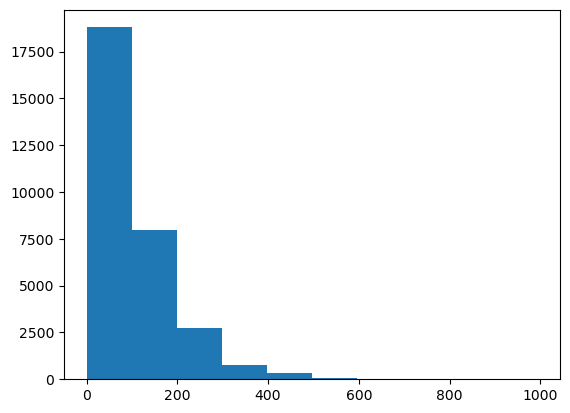

In [6]:
plt.hist(train['pm2.5'])
plt.show() #Just to see the distribution of the PM 2.5

In [7]:
# Extract different date fields
train['year'] = train.index.year
train['month'] = train.index.month
train.reset_index(inplace=True)
train['week'] = train['datetime'].dt.isocalendar().week
train['day_of_year'] = train['datetime'].dt.day_of_year
train['hour'] = train['datetime'].dt.hour
train['day'] = train['datetime'].dt.dayofweek
train['day_str'] = train['datetime'].dt.strftime('%a')
train['year_month'] = train['datetime'].dt.strftime('%Y_%m')
train.set_index('datetime', inplace=True)

train.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,year,month,week,day_of_year,hour,day,day_str,year_month
datetime,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,2010,1,53,1,0,4,Fri,2010_01
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,2010,1,53,1,1,4,Fri,2010_01
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,2010,1,53,1,2,4,Fri,2010_01
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,2010,1,53,1,3,4,Fri,2010_01
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,2010,1,53,1,4,4,Fri,2010_01


In [8]:
columns_to_drop = [
  'year',
  'month',
  'week',
  'day_of_year',
  'hour',
  'day',
  'day_str',
  'year_month',
  'No',
  'Is',
  'Ir',
  'cbwd_NW',
  'cbwd_SE',
  'cbwd_cv'
]

train = train.drop(columns_to_drop, axis=1)

In [9]:
X = train.drop('pm2.5', axis=1)
y = train['pm2.5']

In [10]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X = np.expand_dims(X, axis=1)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import RootMeanSquaredError

# Define the model
model = Sequential([
    LSTM(128, activation='relu', dropout=0.3, return_sequences=True, 
         kernel_regularizer=l2(0.001), input_shape=(X.shape[1], X.shape[2])),
    BatchNormalization(),
    LSTM(64, activation='relu', dropout=0.3, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1)
])

# Compile the model with adjusted learning rate
optimizer = Adam(learning_rate=0.001)  # Lowered learning rate for stability
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

# Display the model architecture
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.0001)

C:\Users\begat\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,545 (486.50 KB)

 Trainable params: 124,161 (485.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    X, y,
    epochs=100,  # Increase the number of epochs
    batch_size=32,  # Adjust batch size
    validation_split=0.2,  # Use a validation set
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 9680.4375 - root_mean_squared_error: 97.8115 - val_loss: 8331.1465 - val_root_mean_squared_error: 91.2733 - learning_rate: 0.0010
Epoch 2/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6881.0527 - root_mean_squared_error: 82.9444 - val_loss: 8292.1250 - val_root_mean_squared_error: 91.0592 - learning_rate: 0.0010
Epoch 3/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6812.7017 - root_mean_squared_error: 82.5332 - val_loss: 7761.4624 - val_root_mean_squared_error: 88.0970 - learning_rate: 0.0010
Epoch 4/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6808.8389 - root_mean_squared_error: 82.5043 - val_loss: 8245.2734 - val_root_mean_squared_error: 90.8012 - learning_rate: 0.0010
Epoch 5/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6721.9458 - root_mean_squared_error: 81.9734 - val_loss: 8019.0977 - val_root_mean_squared_error: 89.5470 - learning_rate: 0.0010
Epoch 6/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3

959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


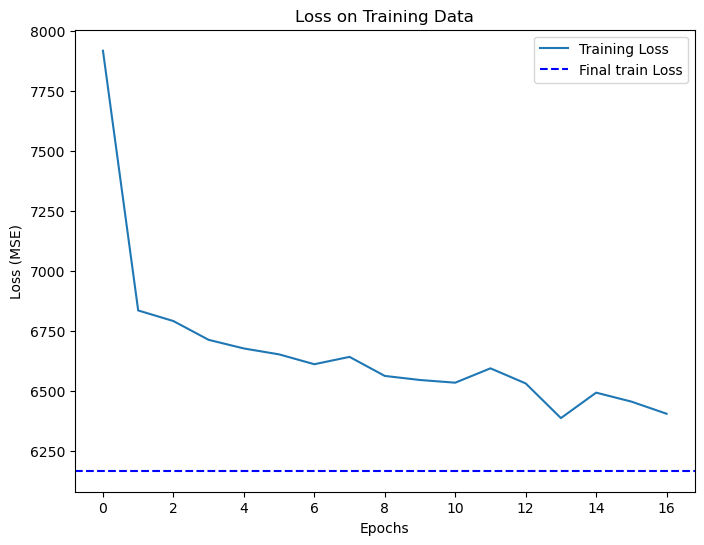

Final Training Loss (MSE): 6169.149276698027


In [13]:
# Calculate training loss
train_predictions = model.predict(X)
train_loss = np.mean((y - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [14]:
rmse = np.sqrt(train_loss)
print("RMSE: ", rmse)

RMSE:  78.54393214436126


In [15]:
# Load sample submission file to maintain structure
sample_sub = pd.read_csv('sample_submission .csv')

# Prepare the test data (same as before)
X_test = test.drop(['No', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions
predictions = model.predict(X_test)
predictions = np.nan_to_num(predictions)

# Convert predictions to integers (if required by competition rules)
predictions = np.round(predictions).astype(int)

# Create submission dataframe with proper ID format
submission = pd.DataFrame({
    'row ID': test.index.strftime('%Y-%m-%d %H:%M:%S').str.replace(" 0", " ", regex=False),  # Fix hour formatting
    'pm2.5': predictions.flatten()
})

# Merge with sample submission to ensure identical structure
submission = sample_sub[['row ID']].merge(submission, on='row ID', how='left')

# Save submission
submission.to_csv('final_submissionnn.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
